<a href="https://colab.research.google.com/github/ryukkt62/ktkim/blob/main/(LSTM%2CDNN)%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%20%EC%A3%BC%EA%B0%80%20%EC%98%88%EC%B8%A1/(LSTM%EC%95%99%EC%83%81%EB%B8%94)%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다:1 LSTM앙상블 모델로 예측

In [ ]:
!pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=1448b822096679875d58b7f214e936aab8de3d137d5e32764ffe85d40567e13b
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=3794954de39ffff22793f2531312c24a815c2fe1e102cd757220012cb538802e
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=753e09e5fd11205e020099696d1eb70084dc9f02b0d7a6027ec9633123c4f03a
  Stored in directo

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,LSTM
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

In [ ]:
# 구글 드라이브에 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# STEP 1: 데이터 Load & 전처리

In [ ]:
path ='/content/drive/MyDrive/Colab Notebooks/딥러닝으로 걷는 시계열 예측/'
kospi200 = np.load(path + 'data/kospi200.npy')
samsung = np.load(path + 'data/samsung.npy')

In [ ]:
display(kospi200.shape)
display(samsung.shape)

(426, 5)

(426, 5)

In [ ]:
samsung

array([[   53000.,    53900.,    51800.,    51900., 39565391.],
       [   52600.,    53200.,    51900.,    52600., 23104720.],
       [   52600.,    52800.,    50900.,    50900., 16128305.],
       ...,
       [   59100.,    59700.,    58800.,    59100., 16446102.],
       [   58800.,    58800.,    56800.,    57200., 20821939.],
       [   57800.,    58400.,    56400.,    56400., 19749457.]])

In [ ]:
def split_xy5(dataset,time_steps,y_column):
    x,y=list(),list()
    for i in range(len(dataset)):
        x_end_number = i+time_steps
        y_end_number = x_end_number+y_column

        if y_end_number > len(dataset):
            break

        tmp_x = dataset[i:x_end_number,:]
        tmp_y = dataset[x_end_number:y_end_number,3]

        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x),np.array(y)

# time_steps는 5개씩 학습
# y_columns은 target값이 몇번째 변수인지, 여기선 3번째 컬럼
# 5일동안의 데이터  학습 뒤 6일째 데이터 예측
x,y=split_xy5(samsung,5,1)

In [ ]:
# 삼성전자와 KOPSPI200 데이터 사용
x1, y1 = split_xy5(samsung,5,1)
x2, y2 = split_xy5(kospi200,5,1)
print(x2[0,:],"\n",y2[0])
print(x2.shape)
print(y2.shape)

[[   320.56    321.      316.75    316.75 173911.  ]
 [   317.79    319.53    314.95    315.87 141252.  ]
 [   315.93    316.08    312.6     314.42 123610.  ]
 [   316.51    317.34    315.11    317.31 120900.  ]
 [   318.03    319.7     317.86    318.51 112400.  ]] 
 [317.72]
(421, 5, 5)
(421, 1)


In [ ]:
# train, test 나누기
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,random_state=1,test_size=0.3)
x2_train,x2_test,y2_train,y2_test = train_test_split(x2,y2,random_state=2,test_size=0.3)

print(x2_train.shape)
print(x2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(294, 5, 5)
(127, 5, 5)
(294, 1)
(127, 1)


In [ ]:
# StandardScaler를 사용해서 전처리
# StandardScaler는 2차원 구조만 받으므로 reshape 필요

x1_train = np.reshape(x1_train,
 (x1_train.shape[0], x1_train.shape[1] * x1_train.shape[2]))
x1_test = np.reshape(x1_test,
 (x1_test.shape[0], x1_test.shape[1] * x1_test.shape[2]))

x2_train = np.reshape(x2_train,
 (x2_train.shape[0], x2_train.shape[1] * x2_train.shape[2]))
x2_test = np.reshape(x2_test,
 (x2_test.shape[0], x2_test.shape[1] * x2_test.shape[2]))

print(x2_train.shape)
print(x2_test.shape)

(294, 25)
(127, 25)


In [ ]:
# StandardScaler

# samsung data
scaler1 = StandardScaler()
scaler1.fit(x1_train)
x1_train_scaled = scaler1.transform(x1_train)
x1_test_scaled = scaler1.transform(x1_test)

# kospi data
scaler2 = StandardScaler()
scaler2.fit(x2_train)
x2_train_scaled = scaler1.transform(x2_train)
x2_test_scaled = scaler1.transform(x2_test)

print(x2_train_scaled[0,:])

[-10.88664987 -11.00113207 -10.96045652 -11.00448062  -2.61390901
 -10.83820833 -10.89506365 -10.90529232 -10.8980913   -2.27638932
 -10.76475285 -10.83974628 -10.85273565 -10.80790425  -2.18405059
 -10.66844317 -10.76028448 -10.69546479 -10.70928217  -2.20759752
 -10.57362195 -10.63956465 -10.58741645 -10.55702221  -2.6641292 ]


In [ ]:
# LSTM은 DNN과 다르게 input 조정해주기
# (None,25)로 reshape한걸 다시 (None,5,5)로 reshape해주기
# 2차원 -> 3차원으로 다시 바꿔주기
# DNN과 input이 달라지는 부분
x1_train_scaled = np.reshape(x1_train_scaled,
 (x1_train_scaled.shape[0],5,5))
x1_test_scaled = np.reshape(x1_test_scaled,
 (x1_test_scaled.shape[0],5,5))
x2_train_scaled = np.reshape(x2_train_scaled,
 (x2_train_scaled.shape[0],5,5))
x2_test_scaled = np.reshape(x2_test_scaled,
 (x2_test_scaled.shape[0],5,5))

print(x2_train_scaled.shape)
print(x2_test_scaled.shape)

(294, 5, 5)
(127, 5, 5)


# STEP 2: 다:1모델 DNN앙상블

In [ ]:
# 모델 구성
input1 = Input(shape=(5,5))
dense1 = LSTM(64)(input1)
dense1 = Dense(32)(dense1)
dense1 = Dense(32)(dense1)
output1 = Dense(32)(dense1)

input2 = Input(shape=(5,5))
dense2 = LSTM(64)(input2)
dense2 = Dense(64)(dense2)
dense2 = Dense(64)(dense2)
dense2 = Dense(64)(dense2)
output2 = Dense(32)(dense2)

In [ ]:
merge = Concatenate()([output1, output2])
output3 = Dense(1)(merge)

model = Model(inputs=[input1, input2],
              outputs = output3)

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

early_stopping = EarlyStopping(patience=20)
# train으로 사용하는건 samsung과 kospi모두 사용하지만 맞춰야하는 정답값은 samsung이므로 y1만 사용
history_model = model.fit([x1_train_scaled,x2_train_scaled],y1_train,validation_split=0.2,verbose=1,
                          batch_size=1,epochs=100,callbacks=[early_stopping])

Epoch 1/100
235/235 [==============================] - 7s 9ms/step - loss: 648665856.0000 - mse: 648665856.0000 - val_loss: 19739130.0000 - val_mse: 19739130.0000
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 13103217.0000 - mse: 13103217.0000 - val_loss: 7494124.5000 - val_mse: 7494124.5000
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 3103578.5000 - mse: 3103578.5000 - val_loss: 2498745.7500 - val_mse: 2498745.7500
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 1826947.3750 - mse: 1826947.3750 - val_loss: 1111581.1250 - val_mse: 1111581.1250
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 1235562.7500 - mse: 1235562.7500 - val_loss: 1094081.7500 - val_mse: 1094081.7500
Epoch 6/100
235/235 [==============================] - 2s 9ms/step - loss: 1210814.2500 - mse: 1210814.2500 - val_loss: 868064.0625 - val_mse: 868064.0625
Epoch 7/100
235/235 [==============================]

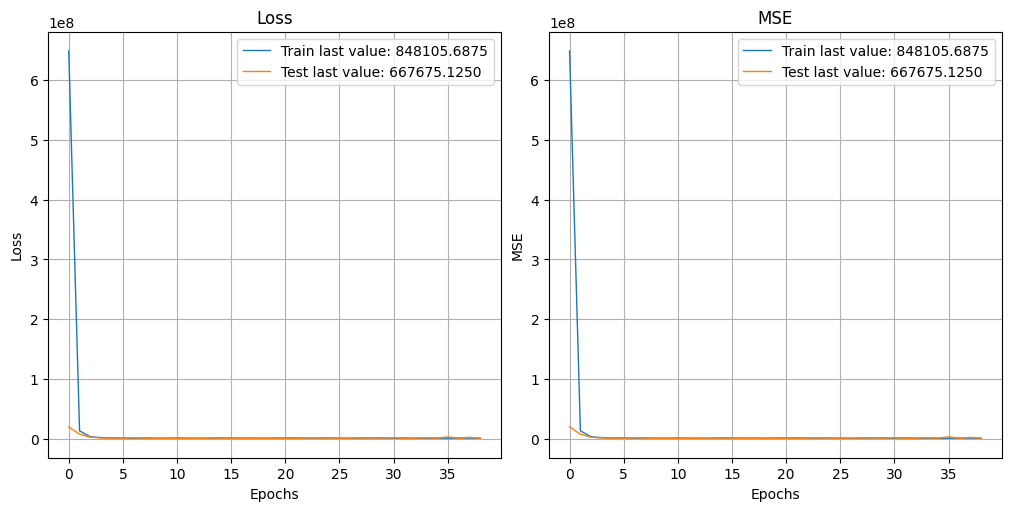

In [ ]:
plot_history(history_model.history)
plt.show()
# plot_history(model.history, path = '(hist)CNN_raw.png')
# plt.close()

In [ ]:
loss, mse = model.evaluate([x1_test_scaled,x2_test_scaled], y1_test, batch_size=1)
print('loss: ',loss)
print('mse :', mse)

127/127 [==============================] - 0s 2ms/step - loss: 816351.5000 - mse: 816351.5000
loss:  816351.5
mse : 816351.5


In [ ]:
y1_pred = model.predict([x1_test_scaled,x2_test_scaled])

for i in range(5):
    print('종가 : ', y1_test[i], '/ 예측가 : ', y1_pred[i])

4/4 [==============================] - 2s 5ms/step
종가 :  [52200.] / 예측가 :  [53350.465]
종가 :  [41450.] / 예측가 :  [40347.242]
종가 :  [49650.] / 예측가 :  [50101.387]
종가 :  [44800.] / 예측가 :  [46644.293]
종가 :  [49500.] / 예측가 :  [50140.184]
